In [1]:
import numpy as np
import time
import scipy.stats as stats
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.metrics import log_loss
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.pyplot as plt
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)

# Explore and extra data of particular periods of interest

In [2]:
data = pd.read_sas('/home/guangya/Downloads/wnv_2245new.sas7bdat') #Data from week 22 to 45, which is what i used for latter models

In [3]:
data.head() # Available features in the data set, More description is the final.xlsw file

,hexid,Input_FID,tempc,preci,yr,weeks,yrweeks,yrwksfid,templag1,templag2,...,wwpct,ehwpct,yr_hexid,Jantemp,PopYesNo,hpctpreww,hpctpostww,hpct7089,hpctpost90,income1
0,1.0,130.0,16.9758,6.046130,2005.0,22.0,b'200522',b'200522130',15.9957,13.7796,...,27.184466,0.0,"b'2005,1'",-3.815482,1.0,0.0,0.0,0.0,0.0,41.979816
1,1.0,130.0,25.3449,58.968242,2005.0,23.0,b'200523',b'200523130',16.9758,15.9957,...,27.184466,0.0,"b'2005,1'",-3.815482,1.0,0.0,0.0,0.0,0.0,41.979816
2,1.0,130.0,21.0872,15.114200,2005.0,24.0,b'200524',b'200524130',25.3449,16.9758,...,27.184466,0.0,"b'2005,1'",-3.815482,1.0,0.0,0.0,0.0,0.0,41.979816
3,1.0,130.0,22.3485,0.000000,2005.0,25.0,b'200525',b'200525130',21.0872,25.3449,...,27.184466,0.0,"b'2005,1'",-3.815482,1.0,0.0,0.0,0.0,0.0,41.979816
4,1.0,130.0,25.7740,6.371029,2005.0,26.0,b'200526',b'200526130',22.3485,21.0872,...,27.184466,0.0,"b'2005,1'",-3.815482,1.0,0.0,0.0,0.0,0.0,41.979816


In [4]:
data.isna().sum() # Check na

hexid               0
Input_FID           0
tempc               0
preci               0
yr                  0
weeks               0
yrweeks             0
yrwksfid            0
templag1            0
templag2            0
templag3            0
templag4            0
precilag1           0
precilag2           0
precilag3           0
precilag4           0
wnvbinary           0
mirmean             0
year           150510
mirlag1             0
mirlag2             0
mirlag3             0
mirlag4             0
totpop              0
whitepct            0
blackpct            0
asianpct            0
hispanicpct         0
Income              0
owpct               0
dospct              0
dlipct              0
dmipct              0
dhipct              0
blpct               0
dfpct               0
efpct               0
mfpct               0
shrubpct            0
glandpct            0
pasturepct          0
ccpct               0
wwpct               0
ehwpct              0
yr_hexid            0
Jantemp   

In [5]:
data.drop(columns=['wnvbinary','yrweeks','yrwksfid','yr_hexid','year']).isna().sum() # Drop year column so that so na appear

hexid          0
Input_FID      0
tempc          0
preci          0
yr             0
weeks          0
templag1       0
templag2       0
templag3       0
templag4       0
precilag1      0
precilag2      0
precilag3      0
precilag4      0
mirmean        0
mirlag1        0
mirlag2        0
mirlag3        0
mirlag4        0
totpop         0
whitepct       0
blackpct       0
asianpct       0
hispanicpct    0
Income         0
owpct          0
dospct         0
dlipct         0
dmipct         0
dhipct         0
blpct          0
dfpct          0
efpct          0
mfpct          0
shrubpct       0
glandpct       0
pasturepct     0
ccpct          0
wwpct          0
ehwpct         0
Jantemp        0
PopYesNo       0
hpctpreww      0
hpctpostww     0
hpct7089       0
hpctpost90     0
income1        0
dtype: int64

In [6]:
x_total = data.drop(columns=['wnvbinary','yrweeks','yrwksfid','yr_hexid','year']).values # Drop extra column
y_total = data['wnvbinary'].values

In [7]:
x_total = x_total.astype('float64')

In [8]:
# some spot check for data
data[data['hexid'] == 1431]['blackpct'].unique()

array([4.28479215])

In [9]:
data[data['hexid'] == 1831]['whitepct'].unique()

array([86.10261915])

In [10]:
data[data['hexid'] == 1831]['dmipct'].unique() 

array([14.42441054])

In [11]:
data[data['hexid'] == 3121]['income1'].unique() # The Geological and social data is likely a 10 year estimate here, which does not change from 2005-2016

array([100.88401563])

In [12]:
x = data[['yr','templag2','templag3','templag4','precilag2','mirlag1','mirlag2','mirlag3','mirlag4', 'whitepct','owpct','dmipct','dhipct']].values
# Data set for the best model described in paper, table5.
# However, random forest use a different feature selection algorithm 
# so that this might not be the optimal one for oue models. Since it's much slower to train all, I will use ALL features for further optimization later
y = data['wnvbinary'].values 
x = x.astype('float64')

In [13]:
trainX, testX, trainY, testY = train_test_split(x, y, test_size = 0.2, shuffle = True) # CV

In [14]:
trainX_total, testX_total, trainY_total, testY_total = train_test_split(x_total, y_total, test_size = 0.2, shuffle = True) # CV for all

# Test on Random Forest

In [15]:
def model_RF_test(model_RF, dataX, dataY):
    print("Model performance")
    predict_data = model_RF.predict_proba(dataX)
    
    # Some stats
    print("Feature Importantce : ")
    print(model_RF.feature_importances_)
    print("Total number of WNV occurence in test set : " + str(len(dataY[dataY > 0])))
    
    print("Number of WNV occurence the model is able to capture in test set:" + str(dataY[np.where(predict_data[:,1]  > 0)].sum()))
    
    print("Log loss : " + str(log_loss(dataY,predict_data)))
    
    print("This is to test the performance of random forest model, ideally, the logloss is low and also it is able to capture most of the WNV occurence")
    
    return None # Check how many wnv it predicts

In [16]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(trainX_total, trainY_total)
time_start = time.time()
model_RF1 = RandomForestClassifier(n_estimators=400,
                                 n_jobs = -1,
                                 max_features=None,
                                 max_depth= None,
                                 bootstrap=True,
                                class_weight='balanced'
                                 ) # Use undersampling to see if it worked
model_RF1.fit(X_resampled, y_resampled)
print("time consumed:", time.time() - time_start) 

Using TensorFlow backend.


time consumed: 2.871291399002075


In [18]:
model_RF_test(model_RF1,testX_total,testY_total) # The result tend to predict a lot of 1s, which is very biased.

Model performance
Feature Importantce : 
[7.09196310e-03 7.53362044e-03 1.90075515e-02 1.04590258e-02
 6.18037323e-03 2.45773112e-02 1.62605914e-02 3.81760369e-02
 4.99353706e-02 3.33698742e-02 1.22033541e-02 1.30757554e-02
 1.16773422e-02 1.18295959e-02 2.97150587e-02 7.57079889e-02
 2.64417876e-01 5.14867961e-02 1.68223411e-02 1.14003780e-01
 8.47291264e-03 8.09103360e-03 1.03671121e-02 9.23056893e-03
 6.32583367e-03 3.56820540e-03 8.98757762e-03 1.11101833e-02
 1.05426256e-02 1.11805300e-02 9.85908487e-04 2.61677480e-03
 1.02658024e-03 6.47040070e-03 5.71674404e-04 1.65545422e-03
 2.30375726e-04 8.43078627e-04 2.28602150e-03 6.85520829e-05
 3.04832743e-02 0.00000000e+00 1.05016538e-02 1.11241305e-02
 1.01154678e-02 1.36854958e-02 5.92696781e-03]
Total number of WNV occurence in test set : 186
Number of WNV occurence the model is able to capture in test set:186.0
Log loss : 0.42245898690507283
This is to test the performance of random forest model, ideally, the logloss is low and als

In [ ]:
x = [4,7,9,10,6,11,3]
seq = sorted(x)
index = [seq.index(v) for v in x]

In [20]:
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(trainX, trainY)
time_start = time.time()
model_RF2 = RandomForestClassifier(n_estimators=400,
                                 n_jobs = -1,
                                 max_features=None,
                                 max_depth= None,
                                 bootstrap=True,
                                class_weight='balanced'
                                 ) # Use undersampling to see if it worked
model_RF2.fit(X_resampled, y_resampled)
print("time consumed:", time.time() - time_start) 

time consumed: 1.2555787563323975


In [21]:
model_RF_test(model_RF2,testX,testY) 

Model performance
Feature Importantce : 
[0.02584675 0.08165917 0.08899662 0.06676306 0.04384553 0.08717681
 0.33089691 0.07172063 0.04496314 0.04041669 0.02299723 0.05860248
 0.03611496]
Total number of WNV occurence in test set : 158
Number of WNV occurence the model is able to capture in test set:158.0
Log loss : 0.4419616218196568
This is to test the performance of random forest model, ideally, the logloss is low and also it is able to capture most of the WNV occurence


In [ ]:
time_start = time.time()
model_RF3 = RandomForestClassifier(n_estimators=400,
                                 n_jobs = -1,
                                 max_features=None,
                                 max_depth= None,
                                 bootstrap=True,
                                class_weight='balanced'
                                 ) # Try more trees and see if calibration curve gets better
model_RF3.fit(trainX_total, trainY_total)
print("time consumed:", time.time() - time_start) 

In [ ]:
time_start = time.time()
model_RF4 = RandomForestClassifier(n_estimators=400,
                                 n_jobs = -1,
                                 max_features=None,
                                 max_depth= None,
                                 bootstrap=True,
                                class_weight='balanced'
                                 ) # Try more trees and see if calibration curve gets better
model_RF4.fit(train_X, train_Y)
print("time consumed:", time.time() - time_start) 

In [104]:
data.drop(columns=['wnvbinary','yrweeks','yrwksfid','yr_hexid','year']).columns[[17,20,9,10,16,18]]

Index(['mirlag3', 'whitepct', 'templag4', 'precilag1', 'mirlag2', 'mirlag4'], dtype='object')

In [77]:
model_RF3.feature_importances_ # The Top 6 most important features here are 

array([8.88704331e-03, 8.84480099e-03, 1.68290411e-02, 1.52045984e-02,
       5.75101814e-03, 2.78785486e-02, 2.04788789e-02, 2.83668125e-02,
       4.98446764e-02, 3.64082202e-02, 1.49555824e-02, 1.42035148e-02,
       1.65239836e-02, 1.22510462e-02, 1.74641244e-02, 5.91554695e-02,
       2.94205558e-01, 3.33941271e-02, 1.77255609e-02, 1.24203733e-01,
       7.01655983e-03, 9.02628399e-03, 8.68760901e-03, 1.06382525e-02,
       5.50246837e-03, 4.21082086e-03, 9.72809643e-03, 1.17033932e-02,
       1.08153860e-02, 9.16551879e-03, 1.04612043e-03, 2.24494907e-03,
       1.35438082e-03, 2.70110347e-03, 4.88967833e-04, 1.61098103e-03,
       7.41166045e-04, 1.21171795e-03, 1.59101536e-03, 1.34623913e-04,
       2.37460250e-02, 0.00000000e+00, 1.15473649e-02, 1.07359273e-02,
       1.14455357e-02, 1.47627672e-02, 5.56662678e-03])

In [239]:
# With more tree, it has a worse looking calibaration curves, but it is able to capture more wnv binary. This is mostly because there are few points that is greater than 0.1, so
# there is a lot of variance here.

In [260]:
model_RF4.feature_importances_

array([0.01850711, 0.0823149 , 0.10578664, 0.0650007 , 0.04608133,
       0.06198855, 0.3301192 , 0.0787663 , 0.05056812, 0.03990346,
       0.02038123, 0.0661462 , 0.03443626])

In [107]:
data[['yr','templag2','templag3','templag4','precilag2','mirlag1','mirlag2','mirlag3','mirlag4', 'whitepct','owpct','dmipct','dhipct']].columns[[2,3,6,7,8]]

Index(['templag3', 'templag4', 'mirlag2', 'mirlag3', 'mirlag4'], dtype='object')

In [ ]:
data[data.drop(columns=['wnvbinary','yrweeks','yrwksfid','yr_hexid','year']).columns[[7,8,9,10,16,17,20]]] # From the above 3 feature importance of models, we can manually select 
# about 7 features which is mostly important

In [32]:
x_selected = data[data.drop(columns=['wnvbinary','yrweeks','yrwksfid','yr_hexid','year']).columns[[7,8,9,10,16,17,20]]]
y_selected = y

In [ ]:
x

### From the above model, we can see that random forest, although is not very good, can actually capture someinformation. So we will try formal Cross validation on selected features and see if it gets betterz

## Pipnelines for later for wrok

In [44]:
trainX_sel, testX_sel, trainY_sel, testY_sel = train_test_split(x_selected.values, y_selected, test_size = 0.2, shuffle = True) # CV

## Find best model 1

In [39]:
time_start = time.time()
params_RF_grid_1 = {
    'n_estimators' : [500, 1000],
    'max_features' : [90, 'sqrt', None],
    'max_depth' : [10, None],
    'min_samples_leaf' : [1,2]
}
CV_model_RF_1 = GridSearchCV(model_RF, params_RF_grid_1, scoring='neg_log_loss',cv=5)
CV_model_RF_1.fit(x_selected, dataY)
print("time consumed:", time.time() - time_start)

time consumed: 6569.04248213768


In [40]:
CV_model_RF_1.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [41]:
CV_model_RF_1.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'n_estimators': 1000}

In [54]:
time_start = time.time()
model_RF_best_1 = RandomForestClassifier(n_estimators=800,
                                 n_jobs = -1,
                                 max_features="sqrt",
                                 max_depth=None,
                                 bootstrap=True,
                                 min_samples_leaf=2
                                 )
model_RF_best_1.fit(trainX_sel,trainY_sel)
print("Time consumed:", time.time() - time_start)

Time consumed: 902.6136860847473


In [55]:
sth = model_RF_best_1.predict_proba(testX_sel)

In [56]:
model_RF_best_1.feature_importances_

array([0.15362526, 0.15291008, 0.15199803, 0.13824163, 0.14013906,
       0.13901935, 0.12406659])

In [67]:
testY_sel[np.where(sth[:,1]  > 0)].sum() 

127.0

In [75]:
len(testY_sel[testY_sel > 0])

174

In [88]:
len(sth[sth[:,1]  > 0])

68106

In [99]:
model_RF_test(model_RF_best_1,testX_sel,testY_sel)

Model performance
Feature Importantce : 
[0.15362526 0.15291008 0.15199803 0.13824163 0.14013906 0.13901935
 0.12406659]
Total number of WNV occurence in test set : 174
Number of WNV occurence the model is able to capture in test set:127.0
Log loss : 0.008746820848036466
This is to test the performance of random forest model, ideally, the logloss is low and also it is able to capture most of the WNV occurence


In [90]:
127/68106

0.0018647402578333774

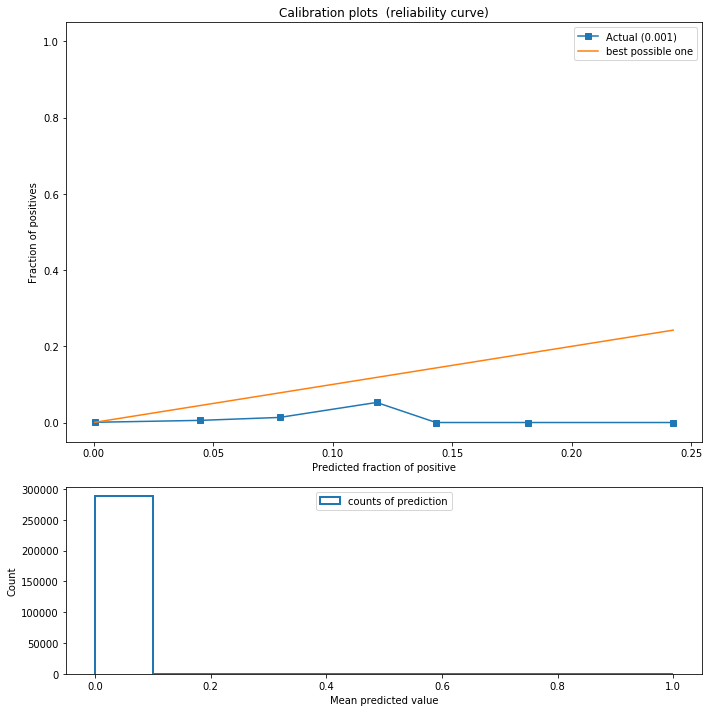

In [87]:
fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
clf_score = brier_score_loss(testY_sel, sth[:,1], pos_label=1)
fraction_of_positives, mean_predicted_value = \
    calibration_curve(testY_sel, sth[:,1], n_bins=30)

ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
         label="%s (%1.3f)" % ('Actual', clf_score))
ax1.plot(mean_predicted_value,mean_predicted_value,label = "best possible one")
ax1.set_xlabel("Predicted fraction of positive")
ax2.hist(sth[:,1], range=(0, 1), bins=10, label='counts of prediction',
         histtype="step", lw=2)
ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="upper right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()

## Find best model 2

In [ ]:
time_start = time.time()
params_RF_grid_2 = {
    'n_estimators' : [800, 1200],
    'max_features' : ['sqrt', 5],
    'min_samples_leaf' : [2,3]
}
CV_model_RF_2 = GridSearchCV(model_RF, params_RF_grid_2, cv=5)
CV_model_RF_2.fit(dataX, dataY)
print("time consumed:", time.time() - time_start)

In [24]:
CV_model_RF_2.fit(dataX, dataY)

KeyboardInterrupt: 

In [ ]:
CV_model_RF_2.best_params_

In [11]:
time_start = time.time()
model_RF_best_2 = RandomForestRegressor(n_estimators=1500,
                                 criterion="mse",
                                 n_jobs = -1,
                                 max_features=None,
                                 max_depth=None,
                                 bootstrap=True,
                                 min_samples_leaf=2
                                 )
model_RF_best_2.fit(trainX, trainY)
print("Time consumed:", time.time() - time_start)

Time consumed: 263.9204020500183


## Find best model 3

In [12]:
time_start = time.time()
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, None, 110],
    'max_features': ['sqrt', 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [500, 2000, 4000, 1000]
}
CV_model_RF_3 = GridSearchCV(model_RF_best_2, params_RF_grid_3, cv=5)
CV_model_RF_3.fit(dataX, dataY)
print("time consumed:", time.time() - time_start)

time consumed: 998.9455091953278


In [13]:
CV_model_RF_3.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='log2', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=3000,
                      n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [14]:
CV_model_RF_3.best_params_

{'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 3000}

In [51]:
time_start = time.time()
model_RF_best_3 = RandomForestRegressor(n_estimators=8000,
                                 criterion="mse",
                                 n_jobs = -1,
                                 max_features="log2",
                                 max_depth=None,
                                 bootstrap=True,
                                 min_samples_leaf=2
                                 )
model_RF_best_3.fit(trainX, trainY)
print("Time consumed:", time.time() - time_start)

Time consumed: 45.644662857055664
